## Part 1: Installing/ Imports

In [1]:
#pip install --user --no-cache-dir nvidia-pyindex

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8418 sha256=043ab605753e7f50b072dfacef07e9b60681694b7dd577a8314268eb05b98b8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0fwwkys3/wheels/05/0a/54/d6d81bbd6c435e7d71c1780ca454a8ae9c655d893225ff1773
Successfully built nvidia-pyindex
Note: you may need to restart the kernel to use updated packages.


In [1]:
#pip install --user --no-cache-dir nvidia-tensorrt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
#conda install defaults tensorflow-gpu


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - defaults

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [8]:
#pip install opencv-python matplotlib imageio gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
#imports
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown


2023-07-13 11:54:41.022221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#GPU Test
tf.config.list_physical_devices('GPU')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Part 2: Data Loading Function

In [2]:
#Download and extract data
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=c4d00726-4071-427d-8e83-e4ea5aaa22d8
To: /home/m245034/projects/LipNet/data.zip
100%|████████████████████████████████████████| 423M/423M [00:04<00:00, 91.5MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [3]:
# Focuses on Lips of Face and turns to data
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #isolates mouth use Dlib to isolate mouth to update
        frames.append(frame[190:236, 80:220,:])        
    cap.release()
    
    #help focus on vital data
    mean = tf.math.reduce_mean(frames)
    std =tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames-mean), tf.float32) / std

In [4]:
#Tests data to charaters translation

# all available charcters
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

#convert text to num and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

#check works and 40 characters 
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})\n"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)



In [5]:
#Align Data and alignments

#use alignments
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        #ignore silence value
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


#load alignements and videos simultaneously
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']




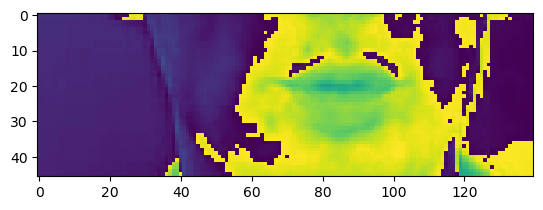

In [6]:
#Test Code

test_path = './data/s1/bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))
# characters from data
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
print('\n')
plt.imshow(frames[25])

In [7]:
#Store result
def mappable_function(path:str) ->List[str]:
    #tensorflow for pure string processing needs py_function
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result



## Part 3: Create Data Pipeline

In [8]:
#make dataset
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
#shuffle data
data = data.shuffle(500, reshuffle_each_iteration=False)
#transfer data through pipeline and get it back
data = data.map(mappable_function)
#ensure 75 frames and 40 tokens
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
#optimizng preloading data
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

frames, alignments = data.as_numpy_iterator().next()
sample = data.as_numpy_iterator()
val =sample.next(); 

In [9]:
#changes dataset into a gif 
fv=(val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif',fv, duration=50)

samp=val[1][1]
print([bytes.decode(x) for x in num_to_char(samp).numpy()])
print('\n')

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'i', 'n', ' ', 'z', ' ', 'o', 'n', 'e', ' ', 's', 'o', 'o', 'n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']




## Part 4: Design Deep Neural Network

In [10]:
#import more dependencies
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [11]:
data.as_numpy_iterator().next()[0][0].shape

model = Sequential()
# 3 sets of convulusions
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#flatten convulsions w/ timedistrubted layer
model.add(TimeDistributed(Flatten()))

#Two sets of LSTMs
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Dense Layer
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [12]:
#Prediction from Data
yhat = model.predict(val[0])


#the predicted output in charactesr
sam=tf.argmax(yhat[0],axis=1)
print([bytes.decode(x) for x in num_to_char(sam).numpy()])

1/1 [==============================] - 3s 3s/step
['l', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'l', 'l', 'l', 'l', 'l', 'l', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 'p', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't']


## Part 5: Training SetUp

In [13]:
#SetUp Training Functions

# define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#define CTC loss
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):    
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

#Compiles our model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [14]:
# Define Callback

#Save model checkpoints
checkpoint_callback = ModelCheckpoint(os.path.join('models2','checkpoint'), monitor='loss', save_weights_only=True) 

#Scheulder should drop the learning rate
schedule_callback = LearningRateScheduler(scheduler)

#make predictions after each epoch
example_callback = ProduceExample(test)

In [15]:
#model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

## Part 6: Make a Prediction

In [16]:
#url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
#output = 'checkpoints.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('checkpoints.zip', 'models2')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=2cbca4fa-f55c-4673-9efd-befee631200d
To: /home/m245034/projects/LipNet/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:03<00:00, 27.3MB/s]


['models2/checkpoint.index',
 'models2/__MACOSX/._checkpoint.index',
 'models2/checkpoint.data-00000-of-00001',
 'models2/__MACOSX/._checkpoint.data-00000-of-00001',
 'models2/checkpoint',
 'models2/__MACOSX/._checkpoint']

In [44]:
model.load_weights('models/checkpoint')

In [45]:
test_data = test.as_numpy_iterator()

In [46]:
sample = test_data.next()

In [47]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [48]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by c nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red with k one again'>]

In [49]:
print('\n')
print('Original:', tf.strings.reduce_join(num_to_char(sample[1][0])).numpy().decode('utf-8'))
print('\n')
print('Original:', tf.strings.reduce_join(num_to_char(sample[1][1])).numpy().decode('utf-8'))
print('\n')



Original: set green by c nine again


Original: place red with k one again




In [50]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [51]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red with one again'>]

In [43]:
print('\n')
print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8'))
print('\n')
print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[1])).numpy().decode('utf-8'))

Prediction: place white by thre again
Prediction: lay blue with five again
